# PredConvLSTM

Training an network for prediction.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, time, math
import input_data.KITTI 
import utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

Remember to specify the GPU to use

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

KITTI = input_data.KITTI.Kitti_Dataset("/home/groupxghan/data/Haleqiu/weather2/my_data/KITTI/tracking/training") 
batchsize = 8
KITTI.predset()

In [3]:
#datadir
DATADIR = "/home/groupxghan/data/Haleqiu/weather2/my_data/KITTI/tracking/training/image_02"
LOGDIR = "/home/groupxghan/data/Haleqiu/VAE/logs/predconvlstm"

Import the basic model

In [4]:
from model.model import Model

# Model for VAE


In [5]:
class ConvLSTMPred(Model):
    """
    This is the prediction network with ConvLSTM
    """
    def __init__(self, batch_size=8, loss = "mse", datadir="./data", logdir = os.getcwd()+"/logs"):
        self.batch_size = batch_size
        self.input = input_data.KITTI.Kitti_Dataset(datadir, self.batch_size) 
        self.input.predset()
        self.logdir = logdir
        self.chanels = 3
        self.timesteps = 6
        self.images = tf.placeholder(tf.float32, [self.batch_size, 256, 256, 3])
        self.videos = tf.placeholder(tf.float32, [self.batch_size, self.timesteps, 256, 256, 3])

        self.enc_dims = [64,64*2,64*4,64*8]
        self.dec_dims = [64,64*2,64*4,64*8]
        
        self.activation = tf.nn.relu
        self.scope_name = "pred"
        self.loss = loss
        self.sess = tf.Session() 
    
    
    def next_batch(self):
        video, image = self.sess.run(self.input.next_batch)
        return video, image
        
    def pred_initializer(self):
        
        self.generator(self.videos)
        
        self.GI_loss = tf.losses.absolute_difference(self.generated_images, self.images)
        #self.KL_loss = self.kl_loss(self.mean_z, self.stdv_z)
        tf.summary.scalar("GI_loss", self.GI_loss)
        #tf.summary.scalar("KL_loss", self.KL_loss)
        #self.cost = tf.reduce_sum(self.KL_loss/(self.batch_size*512*512*32) + self.GI_loss)
        self.cost = tf.reduce_sum(self.GI_loss)
        self.mse_loss = tf.losses.mean_squared_error(self.generated_images,self.images,weights =2.0)
        train_variables = tf.trainable_variables()
        
        self.encoder_variables = [v for v in train_variables if v.name.startswith("encoder")]
        self.decoder_variables = [v for v in train_variables if v.name.startswith("decoder")]

        self.convlstm_variables = [v for v in train_variables if v.name.startswith("convlstm")]
        self.discriminator_variables = [v for v in train_variables if v.name.startswith("discriminator")]
        
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.optimizer = tf.contrib.layers.optimize_loss(loss = self.cost, learning_rate = 0.0001, global_step=self.global_step ,optimizer = "RMSProp",
                                                         summaries = ["gradients", "learning_rate"])
        
        self.tensorboard_summary()
        self.sess.run(tf.global_variables_initializer())

        self.model_load(logdir = self.logdir)
        
        
    def visualization(self):
        """
        this is the function of visualizing the image generated 
        """
        video, image = self.sess.run(self.input.next_batch)
        im = self.sess.run(self.generated_images, feed_dict={self.videos: video, self.images:image})
        gmage = np.where(im >1, 1, im)# the output value may be greater than 1 thus constraint that

        for i in range(self.batch_size):
            fig, axes = plt.subplots(1, 8, figsize=(14, 14))
            ax0, ax1, ax2, ax3,ax4, ax5, ax6, ax7= axes.ravel()
            for j in range(6):
                locals()["ax%d"%j].imshow(video[i][j])
                locals()["ax%d"%j].set_title("step%d"%j)
            ax6.imshow(image[i])
            ax6.set_title("gt")
            ax7.imshow(gmage[i])
            ax6.set_title("generated")
            
            
        
    
    def pred_train(self,train_nums = 100):
        # training for predictions


        for epoch in range(train_nums):
            s_time = time.time()
            for itr in range(self.input.epho_size):
                
                videos, labels = self.sess.run(self.input.next_batch)
                _,cost, GI_loss = self.sess.run((self.optimizer, self.cost ,self.GI_loss), feed_dict={self.videos: videos, self.images: labels})
                # dumb hack to print cost every epoch
                if itr % 100 == 0:
                
                    e_time = time.time()
                    t = e_time - s_time
                    print("epoch %d itr %d time %f: genloss %f cost %f" % (epoch, itr, t, np.mean(GI_loss),cost))
                    s_time = time.time()
                    self.saver.save(self.sess, self.logdir+"/train",global_step=self.global_step)
                    summary_str, mse = self.sess.run((self.summary_op,self.mse_loss), feed_dict={self.videos: videos, self.images: labels})
                    self.summary_writer.add_summary(summary_str, global_step= self.sess.run(self.global_step))
                    print("mseloss: %f"%mse)

In [6]:
model = ConvLSTMPred(datadir = DATADIR ,logdir=LOGDIR)
model.pred_initializer()

initialize the KITTI dataset for pred
scope resue <tensorflow.python.ops.variable_scope.VariableScope object at 0x7f021d2d5128>
scope resue <tensorflow.python.ops.variable_scope.VariableScope object at 0x7f0118193ac8>
scope resue <tensorflow.python.ops.variable_scope.VariableScope object at 0x7f021db30588>
scope resue <tensorflow.python.ops.variable_scope.VariableScope object at 0x7f021d2d5128>
scope resue <tensorflow.python.ops.variable_scope.VariableScope object at 0x7f02214502e8>
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("stack:0", shape=(6, 8, 32, 32, 512), dtype=float32)
Tensor("decoder/h_0:0", shape=(?, 64, 64, 256), dtype=float32)
Tensor("decoder/h_1:0", shape=(?, 128, 128, 128), dtype=float32)
Tensor("decoder/h_2:0", 

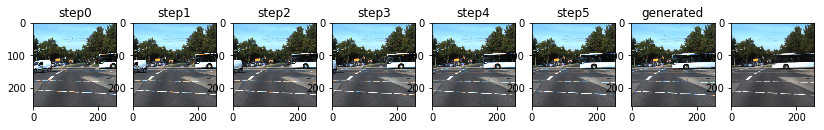

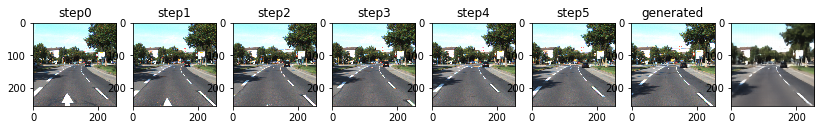

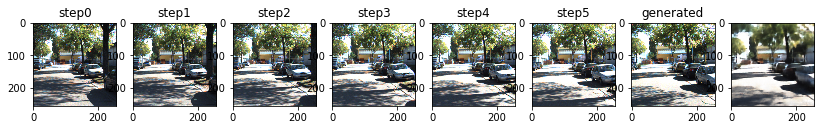

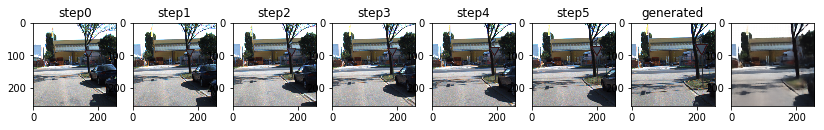

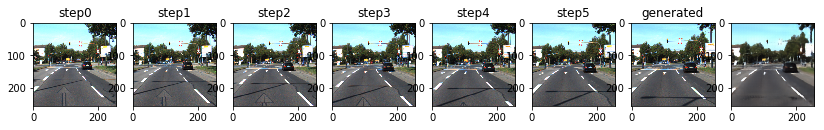

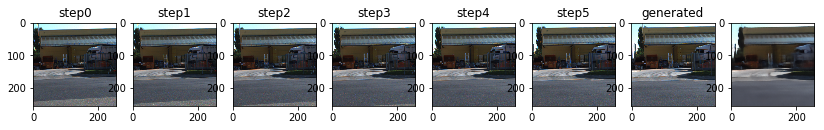

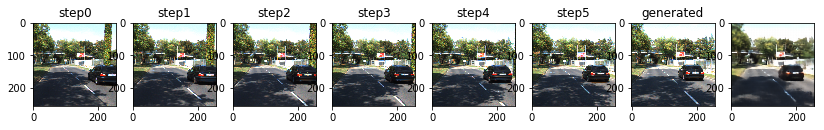

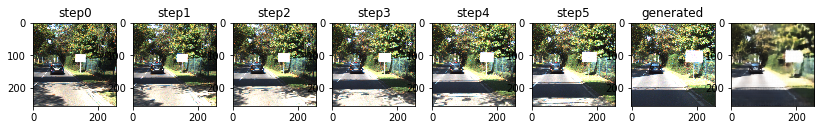

In [7]:
model.visualization()

In [ ]:
model.pred_train()

/home/groupxghan/data/Haleqiu/VAE/logs/predconvlstm
INFO:tensorflow:Restoring parameters from /home/groupxghan/data/Haleqiu/VAE/logs/predconvlstm/train-1
Model restored...
epoch 0 itr 0 time 108.966890: genloss 0.321074 cost 0.321074
mseloss: 0.348625
epoch 0 itr 100 time 255.350708: genloss 0.195417 cost 0.195417
mseloss: 0.121267
epoch 0 itr 200 time 258.401931: genloss 0.146166 cost 0.146166
mseloss: 0.083901
epoch 0 itr 300 time 251.346963: genloss 0.138169 cost 0.138169
mseloss: 0.055533
epoch 0 itr 400 time 254.431182: genloss 0.095067 cost 0.095067
mseloss: 0.048909
epoch 0 itr 500 time 256.091014: genloss 0.097139 cost 0.097139
mseloss: 0.039775
epoch 0 itr 600 time 254.663502: genloss 0.094858 cost 0.094858
mseloss: 0.041821
epoch 0 itr 700 time 255.934342: genloss 0.080310 cost 0.080310
mseloss: 0.030390
epoch 0 itr 800 time 250.306921: genloss 0.092609 cost 0.092609
mseloss: 0.027433
epoch 0 itr 900 time 214.243437: genloss 0.110794 cost 0.110794
mseloss: 0.041029
epoch 1 it

mseloss: 0.012300
epoch 10 itr 0 time 1.649672: genloss 0.048047 cost 0.048047
mseloss: 0.012585
epoch 10 itr 100 time 346.336193: genloss 0.055172 cost 0.055172
mseloss: 0.016101
epoch 10 itr 200 time 256.958006: genloss 0.078944 cost 0.078944
mseloss: 0.035197
epoch 10 itr 300 time 247.255509: genloss 0.069514 cost 0.069514
mseloss: 0.025517
epoch 10 itr 400 time 249.589668: genloss 0.072776 cost 0.072776
mseloss: 0.025926
epoch 10 itr 500 time 253.180846: genloss 0.060285 cost 0.060285
mseloss: 0.020987
epoch 10 itr 600 time 244.892248: genloss 0.070929 cost 0.070929
mseloss: 0.031432
epoch 10 itr 700 time 248.384059: genloss 0.050824 cost 0.050824
mseloss: 0.014534
epoch 10 itr 800 time 242.804408: genloss 0.057727 cost 0.057727
mseloss: 0.021757
epoch 10 itr 900 time 218.166179: genloss 0.040950 cost 0.040950
mseloss: 0.010510
epoch 11 itr 0 time 1.648389: genloss 0.047228 cost 0.047228
mseloss: 0.012496
epoch 11 itr 100 time 353.709443: genloss 0.051818 cost 0.051818
mseloss: 0.0

epoch 20 itr 0 time 1.652751: genloss 0.042735 cost 0.042735
mseloss: 0.012173
epoch 20 itr 100 time 345.842577: genloss 0.050456 cost 0.050456
mseloss: 0.014833
epoch 20 itr 200 time 254.919408: genloss 0.055807 cost 0.055807
mseloss: 0.017556
epoch 20 itr 300 time 249.823116: genloss 0.054551 cost 0.054551
mseloss: 0.018335
epoch 20 itr 400 time 250.899608: genloss 0.059206 cost 0.059206
mseloss: 0.019532
epoch 20 itr 500 time 249.585713: genloss 0.057250 cost 0.057250
mseloss: 0.020490
epoch 20 itr 600 time 246.846083: genloss 0.056831 cost 0.056831
mseloss: 0.019708
epoch 20 itr 700 time 252.499949: genloss 0.050663 cost 0.050663
mseloss: 0.015111
epoch 20 itr 800 time 247.108271: genloss 0.040384 cost 0.040384
mseloss: 0.010634
epoch 20 itr 900 time 226.556076: genloss 0.042929 cost 0.042929
mseloss: 0.012967
epoch 21 itr 0 time 1.635839: genloss 0.048288 cost 0.048288
mseloss: 0.013628
epoch 21 itr 100 time 351.631523: genloss 0.044507 cost 0.044507
mseloss: 0.011261
epoch 21 itr